<a href="https://www.kaggle.com/code/alexandrenouarcto/nvidia-guide-ai?scriptVersionId=207670039" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [24]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install -q kaggle
!pip install -q tensorflow[and-cuda]
!pip install -q keras-tuner
!pip install -q optuna
!pip install -q numba
!pip install -q pyspark
!pip install -q termcolor
!pip install -q seaborn
!pip install -q matplotlib
!pip install -q pandas
!pip install -q numpy
!pip install -q scikit-learn
!pip install -q optuna-integration
!pip install -q numba
%pip install \
    --extra-index-url=https://pypi.nvidia.com \
    "cudf-cu12==24.10.*" "dask-cudf-cu12==24.10.*" "cuml-cu12==24.10.*" \
    "cugraph-cu12==24.10.*" "nx-cugraph-cu12==24.10.*" "cuspatial-cu12==24.10.*" \
    "cuproj-cu12==24.10.*" "cuxfilter-cu12==24.10.*" "cucim-cu12==24.10.*" \
    "pylibraft-cu12==24.10.*" "raft-dask-cu12==24.10.*" "cuvs-cu12==24.10.*" \
    "nx-cugraph-cu12==24.10.*"

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# For example, here's several helpful packages to load



import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



# Input data files are available in the read-only "../input/" directory

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



import os

for dirname, _, filenames in os.walk('/kaggle/input'):

    for filename in filenames:

        print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
import os
import subprocess
import numpy as np
import pandas as pd
import gc
import ctypes
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K, Model, Input, layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Dense, Dropout, Conv1D, BatchNormalization, ReLU, MaxPooling1D, 
                                   GlobalAveragePooling1D, Add, Concatenate, Input, LayerNormalization, 
                                   MultiHeadAttention, Flatten, Reshape, LeakyReLU, Activation, Lambda, Layer)
from tensorflow.keras.backend import clear_session
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, Metric
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.data import Dataset
from keras import mixed_precision

# Machine Learning Libraries
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler as sklearn_StandardScaler

# PySpark Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, monotonically_increasing_id, mean, stddev, when
from pyspark.sql.types import ArrayType, FloatType, IntegerType, DoubleType, StringType
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, VectorAssembler as SparkVectorAssembler, 
                               MinMaxScaler as SparkMinMaxScaler, RobustScaler, 
                               StandardScaler as SparkStandardScaler, PCA as SparkPCA)
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Hyperparameter Tuning Libraries
import keras_tuner as kt
from keras_tuner import HyperParameters, Hyperband
import optuna
from optuna.integration import TFKerasPruningCallback

# GPU Acceleration
from numba import cuda

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utility Libraries
import logging
from termcolor import colored
from math import sqrt
from itertools import count

# 🎮 *NVIDIA GPU GUIDE FOR KAGGLE* 🚀

## 🌟 A Magical Journey Through GPU Computing 🌟

![NVIDIA RTX](https://img.shields.io/badge/NVIDIA-RTX-76B900?style=for-the-badge&logo=nvidia&logoColor=white)



## 🎯 Choose Your Path:



### 1. 🎮 The Gamer's Quest

- Level up from gaming to ML/Data Science mastery

- Harness your GPU's hidden potential



### 2. 🤖 The AI Engineer's Saga 

- From development to production deployment

- Craft powerful AI solutions



### 3. ⚡ The HPC Wizard's Chronicle

- Master the art of High Performance Computing

- Unlock unprecedented computational power



### 4. 🔥 The Enthusiast's Adventure

- Push boundaries with extreme overclocking

- Pioneer cutting-edge AI research



![GPU Architecture](https://img.shields.io/badge/CUDA-Powered-76B900?style=for-the-badge&logo=nvidia&logoColor=white)

In [27]:
# Initialize Spark session for the master node
# 1 - Use all available local cores for the master node
# 2 - Set the application name for the master node
# 3 - Configure the driver and executor memory and GPU settings
import subprocess
import json


# ======================================================================================================#
# =========================================[INIT SPARK]=================================================#
# ======================================================================================================#

# Configure Spark with GPU settings for RTX 4090 (24GB) and A5000 (24GB)
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("ERROR 418 - I'M A TEAPOT") \
    .config("spark.driver.memory", "50g") \
    .config("spark.executor.memory", "50g") \
    .config("spark.driver.maxResultSize", "50g") \
    .config("spark.rapids.sql.enabled", "true") \
    .config("spark.rapids.memory.pinnedPool.size", "24G") \
    .config("spark.rapids.sql.concurrentGpuTasks", "2") \
    .config("spark.rapids.memory.gpu.pooling.enabled", "true") \
    .config("spark.rapids.memory.gpu.allocFraction", "0.95") \
    .config("spark.rapids.sql.explain", "ALL") \
    .config("spark.executor.resource.gpu.amount", "2") \
    .config("spark.task.resource.gpu.amount", "0.25") \
    .config("spark.rapids.sql.incompatibleOps.enabled", "true") \
    .config("spark.rapids.memory.host.spillStorageSize", "64G") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.localShuffleReader.enabled", "true") \
    .config("spark.rapids.memory.gpu.maxAllocFraction", "0.95") \
    .config("spark.rapids.sql.batchSizeBytes", "512M") \
    .config("spark.rapids.sql.reader.batchSizeRows", "100000") \
    .config("spark.rapids.sql.variableRowGroupSize.enabled", "true") \
    .getOrCreate()

gpus = tf.config.list_logical_devices('GPU')
if gpus:
    # Replicate your computation on multiple GPUs
    c = []
    for gpu in gpus:
        with tf.device(gpu.name):
            a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
            b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
            c.append(tf.matmul(a, b))

    with tf.device('/CPU:0'):
        matmul_sum = tf.add_n(c)

    print(matmul_sum)

# Set log level to INFO
spark.sparkContext.setLogLevel("INFO")
# Configure logging
log4jLogger = spark._jvm.org.apache.log4j
logger = log4jLogger.LogManager.getLogger(__name__)

def custom_logger(level, message):
    color = 'white'
    if level == "INFO":
        color = 'cyan'
    elif level == "SUCCESS":
        color = 'green'
    elif level == "ERROR":
        color = 'red'
    elif level == "ACTION":
        color = 'blue'
    elif level == "PROGRESS" or level == "WARNING":
        color = 'yellow'
    elif level == "FINAL":
        color = 'magenta'
    logger.info(colored(f"SPARK: {level} - {message}", color))

# ======================================================================================================#
# =========================================[INIT CUDA]==================================================#
# ======================================================================================================#

# TF_GPU_ALLOCATOR: Controls the GPU memory allocator used by TensorFlow
# Setting to 'cuda_malloc_async' enables asynchronous memory allocation for better performance
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# TF_FORCE_GPU_ALLOW_GROWTH: Controls whether TensorFlow allocates all GPU memory at once
# Setting to 'true' makes memory allocation grow as needed instead of taking all at startup
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# CUDA_DEVICE_ORDER: Determines how CUDA devices are ordered
# "PCI_BUS_ID" makes CUDA devices ordered by their PCI bus IDs for consistent device numbering
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# CUDA_VISIBLE_DEVICES: Specifies which GPUs are visible to the application
# "0, 1" makes only GPUs 0 and 1 visible to the application
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

def initialize_cuda():
    """
    Initializes CUDA and returns handles for all available devices.
    
    Returns:
        list: List of device handles
    """
    # Load the CUDA library
    cuda = ctypes.CDLL('libcuda.so')
    
    # Set up cuInit function for CUDA initialization
    cuInit = cuda.cuInit
    cuInit.restype = ctypes.c_int
    cuInit.argtypes = [ctypes.c_uint]
    
    # Set up cuDeviceGetCount function to get number of CUDA devices
    cuDeviceGetCount = cuda.cuDeviceGetCount
    cuDeviceGetCount.restype = ctypes.c_int
    cuDeviceGetCount.argtypes = [ctypes.POINTER(ctypes.c_int)]
    
    # Set up cuDeviceGet function to get handle to specific device
    cuDeviceGet = cuda.cuDeviceGet
    cuDeviceGet.restype = ctypes.c_int
    cuDeviceGet.argtypes = [ctypes.POINTER(ctypes.c_int), ctypes.c_int]

    # Initialize CUDA driver API
    res = cuInit(0)
    if res != 0:
        raise RuntimeError("Failed to initialize CUDA")
        
    # Get count of available CUDA devices
    device_count = ctypes.c_int()
    res = cuDeviceGetCount(ctypes.byref(device_count))
    if res != 0:
        raise RuntimeError("Failed to get device count")
        
    # Get handles for all available devices
    devices = []
    for i in range(device_count.value):
        device = ctypes.c_int()
        res = cuDeviceGet(ctypes.byref(device), i)
        if res != 0:
            raise RuntimeError(f"Failed to get device {i}")
        devices.append(device.value)
    return devices

def allocate_gpu_memory(size):
    """
    Allocates GPU memory of a given size.
    
    Args:
        size (int): Size of memory to allocate in bytes
        
    Returns:
        int: Pointer to the allocated memory
    """
    # Load CUDA library
    cuda = ctypes.CDLL('libcuda.so')
    
    # Set up memory allocation function
    cuda_malloc = cuda.cuMemAlloc
    cuda_malloc.restype = ctypes.c_int
    cuda_malloc.argtypes = [ctypes.POINTER(ctypes.c_ulonglong), ctypes.c_ulonglong]
    
    # Allocate memory on GPU
    ptr = ctypes.c_ulonglong()
    res = cuda_malloc(ctypes.byref(ptr), size)
    if res != 0:
        raise RuntimeError("Failed to allocate GPU memory")
    return ptr.value

def free_gpu_memory(ptr):
    """
    Frees GPU memory allocated by allocate_gpu_memory.
    
    Args:
        ptr (int): Pointer to the allocated memory
    """
    # Load CUDA library
    cuda = ctypes.CDLL('libcuda.so')
    
    # Set up memory deallocation function
    cuda_free = cuda.cuMemFree
    cuda_free.restype = ctypes.c_int
    cuda_free.argtypes = [ctypes.c_ulonglong]
    
    # Free allocated GPU memory
    res = cuda_free(ptr)
    if res != 0:
        raise RuntimeError("Failed to free GPU memory")

# Check GPU memory usage
def check_gpu_memory():
    """
    Checks GPU memory usage by running nvidia-smi command.
    """
    os.system('nvidia-smi')

# Initialize CUDA
cuda_devices = initialize_cuda()

# Check available GPU memory
check_gpu_memory()

# Ensure TensorFlow uses the GPU by setting memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# Check and print the number of GPUs available
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"Num GPUs Available: {num_gpus}")

# Perform a simple TensorFlow operation to verify GPU usage
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], dtype=tf.float32)
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]], dtype=tf.float32)
    c = tf.matmul(a, b)
print(f"Result of matrix multiplication on GPU:\n{c.numpy()}")

# Get current GPU memory usage using nvidia-smi
def get_gpu_memory_usage():
    """
    Retrieves the current GPU memory usage in MB using nvidia-smi command.
    
    This function executes nvidia-smi with specific query parameters to get memory usage,
    parses the output and returns it as an integer value.
    
    Returns:
        int: The amount of GPU memory currently in use in MB.
        None: If there's an error querying the GPU.
    """
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        memory_used = int(result.stdout.decode('utf-8').strip())
        return memory_used
    except Exception as e:
        print(f"Failed to get GPU memory usage: {e}")
        return None

def freegpu():
    """
    Forcefully frees GPU memory by killing processes using NVIDIA GPUs.
    
    This function:
    1. Gets initial GPU memory usage as baseline
    2. Finds all processes using NVIDIA devices using fuser command
    3. Forcefully terminates these processes with SIGKILL (signal 9)
    
    Note: Requires sudo privileges to run fuser command
    
    Returns:
        None. Prints memory freed or error messages.
    """
    try:
        # Get GPU memory usage before freeing for comparison
        memory_before = get_gpu_memory_usage()

        # Run fuser command to list processes using NVIDIA devices
        result = subprocess.run(['sudo', 'fuser', '-v', '/dev/nvidia*'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        
        # Parse output and kill each process using NVIDIA devices
        for line in result.stdout.decode('utf-8').split('\n'):
            if '/dev/nvidia' in line:
                pid = int(line.split()[-1])  # Extract process ID
                os.kill(pid, 9)  # Send SIGKILL signal

        # Get GPU memory usage after freeing
        memory_after = get_gpu_memory_usage()

        if memory_before is not None and memory_after is not None:
            memory_freed = memory_before - memory_after
            print(f"GPU memory has been freed. {memory_freed} MB of GPU memory was released.")
        else:
            print("GPU memory has been freed.")
    except Exception as e:
        print(f"Failed to free GPU memory: {e}")

# Set the environment variable for XLA flags
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

# ======================================================================================================
# ==============================[SETUP MIRROREDSTRATEGY WITHOUT NCCL]===================================
# ======================================================================================================

# ------------------------------------------------------------------------------------------------------
# Define the strategy with HierarchicalCopyAllReduce to avoid NCCL
# ------------------------------------------------------------------------------------------------------
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1"],
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
)

print(f"Number of devices under strategy: {strategy.num_replicas_in_sync}")

24/11/16 07:12:40 INFO SharedState: Setting hive.metastore.warehouse.dir ('null') to the value of spark.sql.warehouse.dir.
24/11/16 07:12:40 INFO SharedState: Warehouse path is 'file:/home/skander/Documents/GitHub/nvidia_benchmark/spark-warehouse'.


tf.Tensor(
[[ 44.  56.]
 [ 98. 128.]], shape=(2, 2), dtype=float32)
Sat Nov 16 07:12:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0  On |                    0 |
| 33%   63C    P2             83W /  230W |   21188MiB /  23028MiB |     16%      Default |
|                                         |                        |    

### **LazyEval EDA**

In [28]:
# Load and analyze GPU dataset
def load_gpu_dataset():
    """
    Load the GPU dataset from either Kaggle or local path.
    Returns:
        pd.DataFrame: Loaded GPU dataset
    """
    kaggle_path = '/kaggle/input/nvidia-complete-lineup-dataset/Updated_GPU_Dataset_with_Tensor_Core_Information.csv'
    local_path = '/home/skander/datasets/gpu/Updated_GPU_Dataset_with_Tensor_Core_Information copy.csv'
    
    try:
        # Try Kaggle path first
        custom_logger("INFO", "Attempting to load from Kaggle path...")
        data = pd.read_csv(kaggle_path, index_col=False, header=0)
        custom_logger("SUCCESS", "Dataset loaded successfully from Kaggle")
        return data
    except FileNotFoundError:
        try:
            # Try local path if Kaggle fails
            custom_logger("INFO", "Kaggle path failed. Attempting local path...")
            data = pd.read_csv(local_path, index_col=False, header=0)
            custom_logger("SUCCESS", "Dataset loaded successfully from local path")
            return data
        except FileNotFoundError:
            custom_logger("ERROR", "Both Kaggle and local paths failed. Please check file paths.")
            return None

def univariate_analysis(df):
    """
    Perform comprehensive univariate analysis on the DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame for analysis
        
    Prints:
        - Basic dataset information (shape, dtypes)
        - Missing value analysis
        - Duplicate entry analysis
        - Numerical column statistics
        - Detailed NaN value report
    """
    custom_logger("ACTION", "Starting univariate analysis...")
    
    # Dataset overview
    custom_logger("INFO", f"Dataset Shape: {df.shape}")
    custom_logger("INFO", "\nData Types:")
    print(df.dtypes)
    
    # Missing values analysis
    missing_values = df.isnull().sum()
    custom_logger("INFO", "\nMissing Values Summary:")
    print(missing_values)
    
    # Duplicate analysis
    duplicate_count = df.duplicated().sum()
    custom_logger("INFO", f"\nNumber of Duplicate Entries: {duplicate_count}")
    
    # Numerical statistics
    custom_logger("INFO", "\nNumerical Column Statistics:")
    print(df.describe(include=[np.number]))
    
    # Detailed NaN analysis
    custom_logger("INFO", "\nDetailed NaN Value Analysis:")
    for col in df.columns:
        if df[col].isnull().any():
            nan_count = df[col].isnull().sum()
            nan_percentage = df[col].isnull().mean() * 100
            custom_logger("WARNING", f"Column '{col}': {nan_count} NaN values ({nan_percentage:.2f}%)")
    
    custom_logger("FINAL", "Univariate analysis completed")

# Execute the analysis
original_data = load_gpu_dataset()
if original_data is not None:
    custom_logger("INFO", "ORIGINAL DATA - BEFORE PROCESSING")
    univariate_analysis(original_data)


Model                            object
Micro-Architecture / Process     object
Launch                           object
Cuda Cores                       object
Base Clock (MHz)                 object
Max Boost Clock (MHz)            object
Bus Type                         object
Bus Width (bits)                 object
Size (GB)                         int64
Clock (MT/s)                     object
Bandwidth (GB/s)                 object
Half Precision (GFLOPS)          object
Single Precision (GFLOPS)        object
Double Precision (GFLOPS)        object
TDP (Watts)                       int64
 Price                           object
 Scaled Performance HP           object
 Scaled Performance SP           object
 Scaled Performance DP           object
P/P HP (GFLOPS/$)               float64
P/P SP (GFLOPS/$)               float64
P/P DP (GFLOPS/$)               float64
Scaled P/P HP (%)                object
Scaled P/P SP (%)                object
Scaled P/P DP (%)                object


24/11/16 07:12:41 INFO __main__: SPARK: INFO - Attempting to load from Kaggle path...
24/11/16 07:12:41 INFO __main__: SPARK: INFO - Kaggle path failed. Attempting local path...
24/11/16 07:12:41 INFO __main__: SPARK: SUCCESS - Dataset loaded successfully from local path
24/11/16 07:12:41 INFO __main__: SPARK: INFO - ORIGINAL DATA - BEFORE PROCESSING
24/11/16 07:12:41 INFO __main__: SPARK: ACTION - Starting univariate analysis...
24/11/16 07:12:41 INFO __main__: SPARK: INFO - Dataset Shape: (107, 40)
24/11/16 07:12:41 INFO __main__: SPARK: INFO - 
Data Types:
24/11/16 07:12:41 INFO __main__: SPARK: INFO - 
Missing Values Summary:
24/11/16 07:12:41 INFO __main__: SPARK: INFO - 
Number of Duplicate Entries: 27
24/11/16 07:12:41 INFO __main__: SPARK: INFO - 
Numerical Column Statistics:
24/11/16 07:12:41 INFO __main__: SPARK: INFO - 
Detailed NaN Value Analysis:
24/11/16 07:12:41 INFO __main__: SPARK: WARNING - Column 'L2 Cache (MB)': 69 NaN values (64.49%)
24/11/16 07:12:41 INFO __main__

### **Lack of features - adding Tensor Cores, Generation, and End-of-Life**

In [29]:
import pandas as pd

def clean_duplicates(file_path):
    # Read the CSV file
    custom_logger("INFO", "Loading dataset...")
    df = pd.read_csv(file_path)
    
    # Check for duplicates based on Model column
    custom_logger("ACTION", "Checking for duplicate entries...")
    duplicates = df[df.duplicated(subset=['Model'], keep=False)]
    custom_logger("INFO", f"Found {len(duplicates)} duplicate entries")
    
    # Remove duplicates keeping first occurrence
    custom_logger("ACTION", "Removing duplicate entries...")
    df_cleaned = df.drop_duplicates(subset=['Model'], keep='first')
    
    # Save cleaned dataset
    output_path = file_path.replace('.csv', '_cleaned.csv')
    df_cleaned.to_csv(output_path, index=False)
    custom_logger("SUCCESS", f"Cleaned dataset saved to {output_path}")
    
    return df_cleaned, duplicates

# Usage
file_path = '/home/skander/datasets/gpu/Updated_GPU_Dataset_with_Tensor_Core_Information copy.csv'
df_cleaned, duplicates = clean_duplicates(file_path)

# Print duplicate models for verification
custom_logger("INFO", "\nDuplicate Models found:")
for model in duplicates['Model'].unique():
    custom_logger("WARNING", f"Duplicate found: {model}")

24/11/16 07:12:41 INFO __main__: SPARK: INFO - Loading dataset...
24/11/16 07:12:41 INFO __main__: SPARK: ACTION - Checking for duplicate entries...
24/11/16 07:12:41 INFO __main__: SPARK: INFO - Found 82 duplicate entries
24/11/16 07:12:41 INFO __main__: SPARK: ACTION - Removing duplicate entries...
24/11/16 07:12:41 INFO __main__: SPARK: SUCCESS - Cleaned dataset saved to /home/skander/datasets/gpu/Updated_GPU_Dataset_with_Tensor_Core_Information copy_cleaned.csv
24/11/16 07:12:41 INFO __main__: SPARK: INFO - 
Duplicate Models found:
24/11/16 07:12:41 INFO __main__: SPARK: WARNING - Duplicate found: Tesla H100
24/11/16 07:12:41 INFO __main__: SPARK: WARNING - Duplicate found: GeForce RTX 4080
24/11/16 07:12:41 INFO __main__: SPARK: WARNING - Duplicate found: RTX 4500 Ada Generation
24/11/16 07:12:41 INFO __main__: SPARK: WARNING - Duplicate found: Tesla A100 (80 GB)
24/11/16 07:12:41 INFO __main__: SPARK: WARNING - Duplicate found: Tesla A16
24/11/16 07:12:41 INFO __main__: SPARK: WA

#### **Duplicate Elimination**

In [41]:
from cudf import read_csv


df =  pd.read_csv('gpu_cleaned.csv')

def dataset_info(df, name):
    info = {
        "Head": df.head(),
        "Tail": df.tail(),
        "Shape": df.shape,
        "Data Types": df.dtypes,
        "Missing Values": df.isnull().sum(),
        "Duplicates": df.duplicated().sum()
    }
    print(f"Dataset: {name}")
    for key, value in info.items():
        print(f"\n{key}:\n{value}")
    print("\n" + "="*40 + "\n")

# Display information for each dataset
dataset_info(df, "tech specs")

# Copy the datasets to avoid any issues with the original data
df_cleaned = df.copy()

Dataset: tech specs

Head:
                     model     price        market     ecc_equipped  \
0  RTX 6000 Ada Generation   7198.00  Professional              Yes   
1                Tesla L40   8627.99    Datacenter              Yes   
2         GeForce RTX 4090   1948.99      Consumer  Partial Support   
3  RTX 5000 Ada Generation   4499.99  Professional              Yes   
4               Tesla H100  40745.00    Datacenter              Yes   

   architecture release_date  tensor_cores   tensor_core_gen cuda_cores  \
0  Ada Lovelace    12/3/2022           568     4th Gen (Ada)     18,176   
1  Ada Lovelace         8322           568     4th Gen (Ada)     18,176   
2       TSMC 4N         4679           512     4th Gen (Ada)     18,176   
3  Ada Lovelace     8/9/2023           400     4th Gen (Ada)     12,800   
4        Hopper    3/22/2022           640  4th Gen (Hopper)     14,592   

  base_clock_mhz  ...       fp64  tdp       nv_link  bus_interface  \
0            915  ...   1

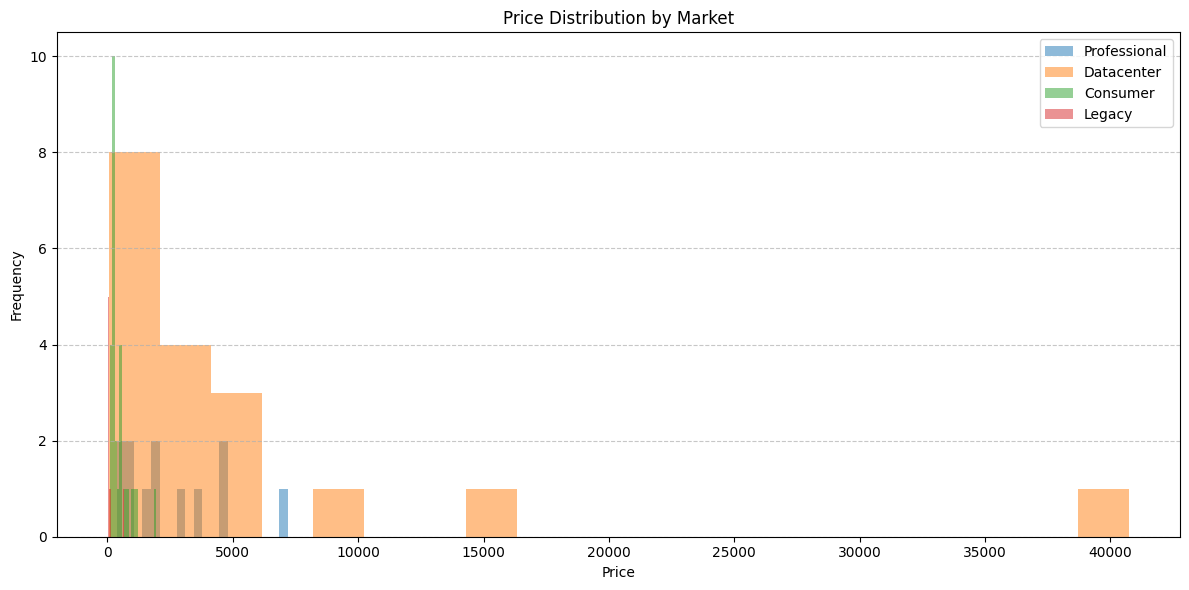

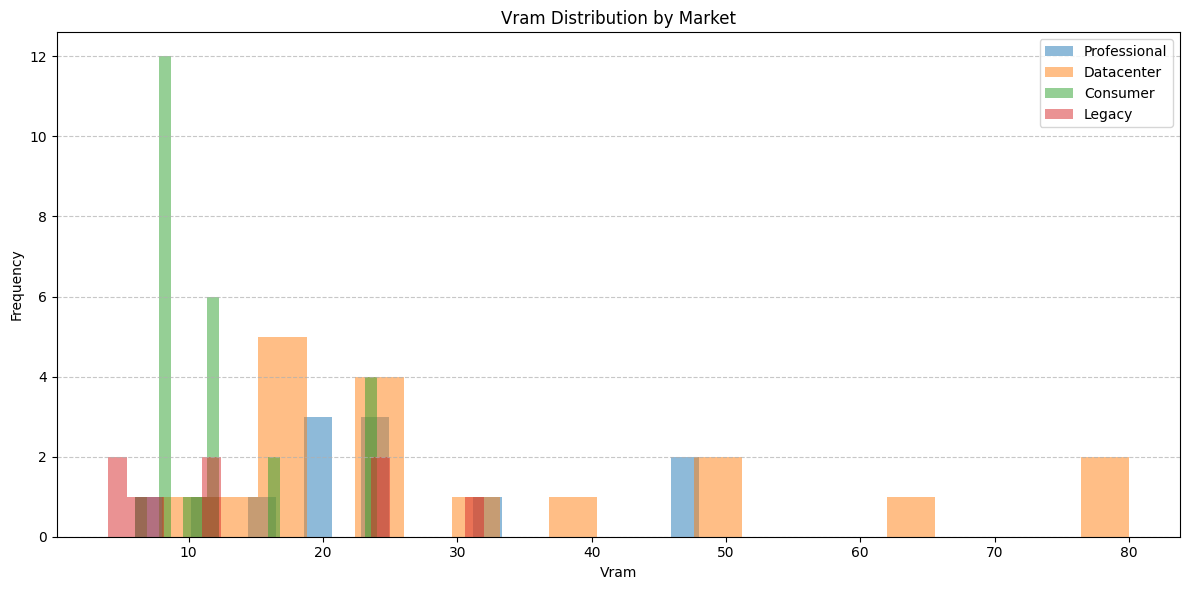

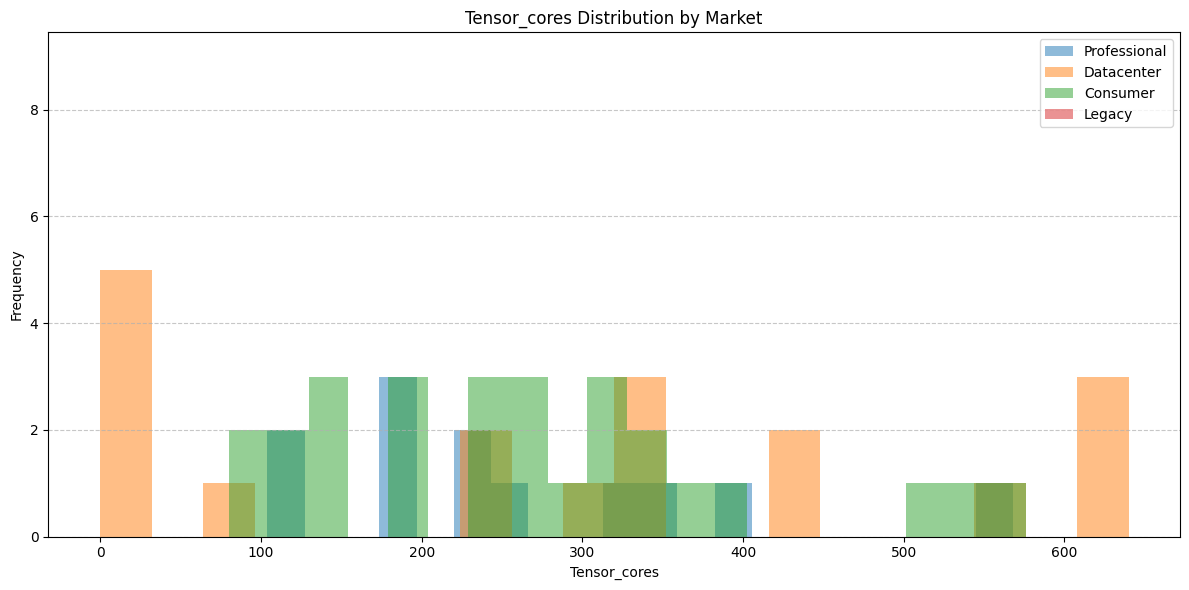

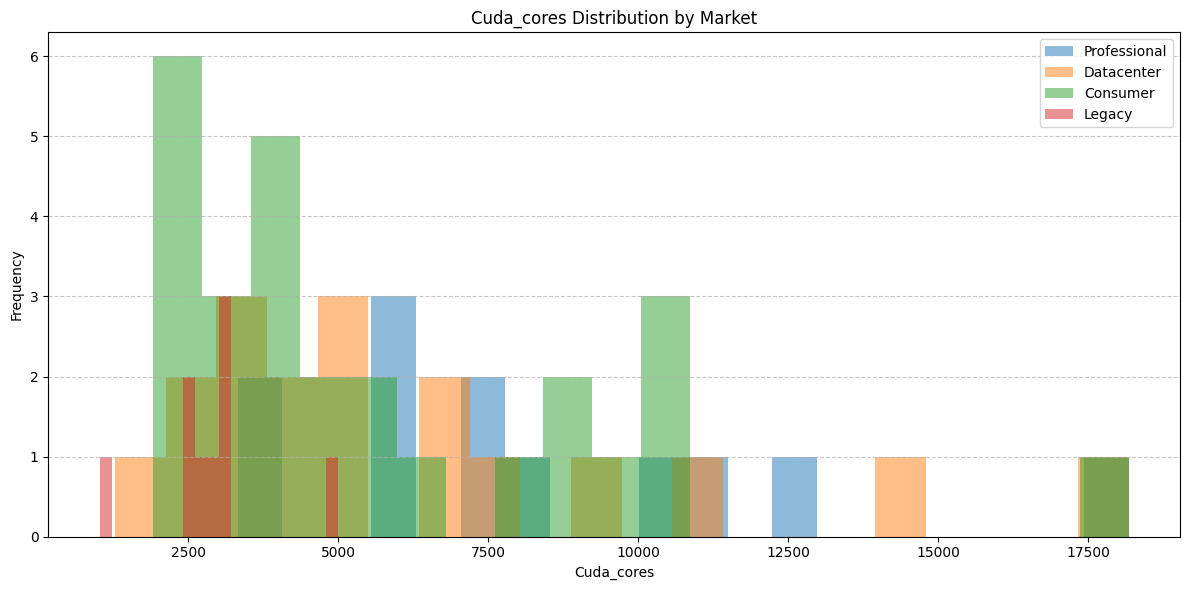

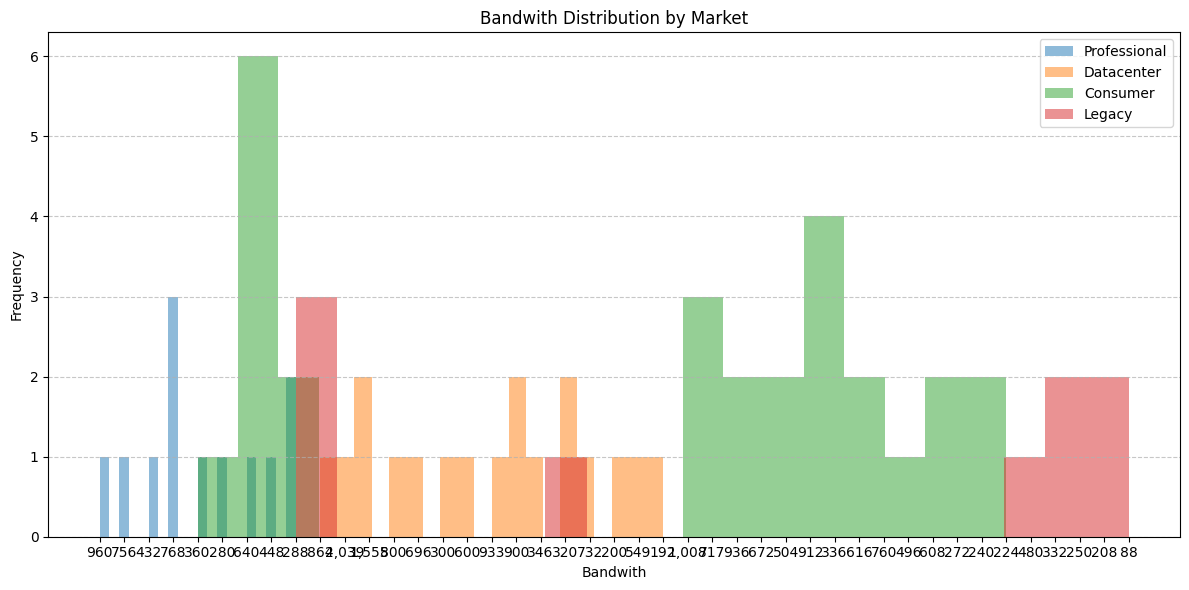

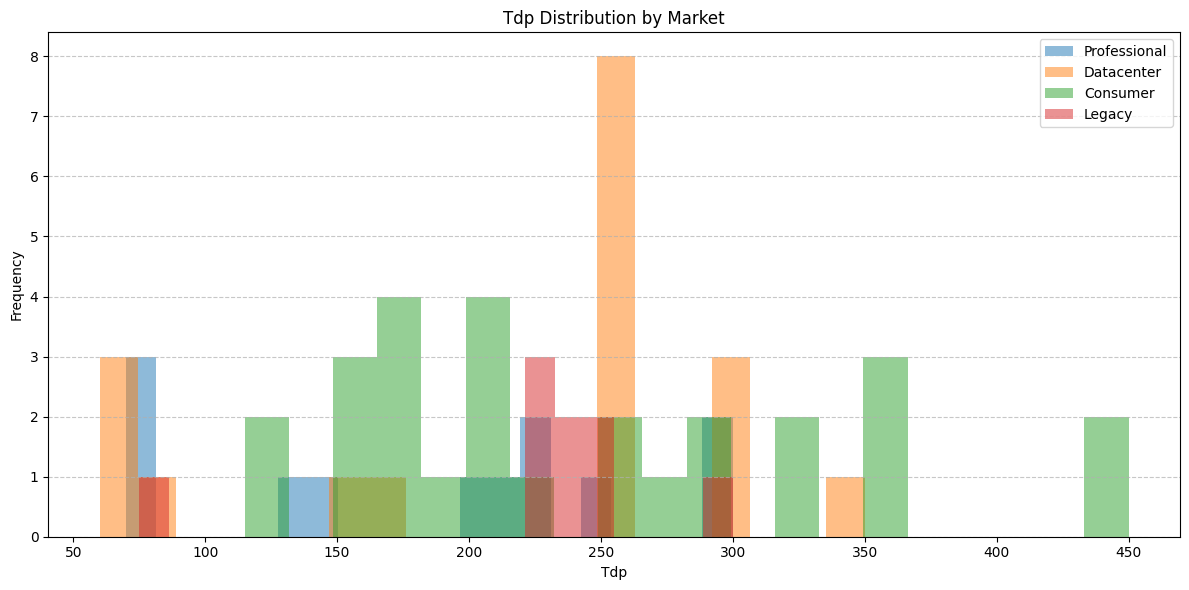

In [56]:

# Safely process the 'cuda_cores' column
if df_cleaned['cuda_cores'].dtype == 'object':  # Check if it's a string
    df_cleaned['cuda_cores'] = df_cleaned['cuda_cores'].str.replace(',', '').astype(float)
else:
    df_cleaned['cuda_cores'] = df_cleaned['cuda_cores'].astype(float)

# List of numeric columns to analyze
columns_to_analyze = ['price', 'vram', 'tensor_cores', 'cuda_cores', 'bandwith', 'tdp']

# List of unique markets
markets = df_cleaned['market'].unique()

# Loop through each column and create visualizations per market
for col in columns_to_analyze:
    plt.figure(figsize=(12, 6))
    for market in markets:
        subset = df_cleaned[df_cleaned['market'] == market]
        plt.hist(subset[col], bins=20, alpha=0.5, label=market)
    plt.title(f'{col.capitalize()} Distribution by Market')
    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Analysis of GPU Market Distribution

## 1. Price Distribution by Market
- **Observations**:
  - Datacenter GPUs dominate the high-end price range (up to $40,000), with few professional GPUs in the upper range.
  - Consumer GPUs are tightly clustered in the lower price range, mostly under $2,000, emphasizing affordability.
  - Legacy GPUs exhibit very low prices, reflecting their outdated nature.

- **Insights**:
  - Datacenter GPUs command premium pricing due to specialized capabilities (e.g., ECC memory, Tensor Cores, high VRAM).
  - Consumer GPUs prioritize affordability for gaming.
  - Professional GPUs bridge the gap, balancing cost and performance for workstation tasks.

---

## 2. VRAM Distribution by Market
- **Observations**:
  - Datacenter GPUs clearly dominate in VRAM, with several models offering **48GB or more**.
  - Consumer GPUs cluster around **8-16GB**, which is sufficient for gaming but inadequate for ML or data processing.
  - Professional GPUs span mid to high VRAM capacities, catering to a wide range of tasks.

- **Insights**:
  - VRAM is the defining feature for datacenter GPUs, necessary for handling large datasets in AI/ML tasks.
  - Consumer GPUs provide just enough VRAM for high-resolution gaming textures, while professional GPUs maintain flexibility for moderate workloads.

---

## 3. Tensor Core Distribution by Market
- **Observations**:
  - Datacenter GPUs have significant outliers (e.g., **600+ Tensor Cores**), likely from the high-end Tesla H100 or similar models.
  - Consumer GPUs often have lower Tensor Core counts, primarily under **300**, focusing on gaming features like DLSS.
  - Legacy GPUs lack Tensor Cores entirely, as they predate this technology.

- **Insights**:
  - Tensor Core count distinguishes datacenter GPUs, optimized for AI/ML tasks.
  - Consumer GPUs use Tensor Cores selectively, primarily for real-time upscaling and DLSS.

---

## 4. CUDA Core Distribution by Market
- **Observations**:
  - CUDA cores are evenly distributed across markets, though datacenter GPUs often exhibit higher counts.
  - Consumer GPUs, particularly gaming GPUs, also feature high CUDA Core counts to optimize for gaming and graphics rendering.
  - The distribution appears chaotic, indicating CUDA cores alone are insufficient for categorization.

- **Insights**:
  - CUDA cores are no longer a primary market differentiator. Specialized cores (e.g., Tensor Cores, RT Cores) now play a larger role.
  - Consumer GPUs emphasize CUDA cores for gaming performance, but this isn’t enough to compete in AI workloads.

---

## 5. TDP (Thermal Design Power) Distribution by Market
- **Observations**:
  - Datacenter GPUs have a very **centered distribution**, with the majority falling around **250-350W**. Low-power datacenter GPUs also exist, visible in the left range.
  - Consumer GPUs show a wider spread, with significant outliers on the right (e.g., likely the RTX 4090).
  - Legacy GPUs tend to have lower TDP, reflecting their less powerful architecture.

- **Insights**:
  - Datacenter GPUs require consistent power consumption, optimized for stability and performance in server environments.
  - Consumer GPUs are less power efficient, with a mix of low and high TDP models, driven by performance demands (e.g., RTX 4090).
  - Professional GPUs balance TDP requirements with workstation usability.

---

## 6. Bandwidth Distribution by Market
- **Observations**:
  - Consumer GPUs dominate in bandwidth, reflecting their need for high-speed memory to support features like **DLSS** and high refresh rates.
  - Datacenter GPUs, surprisingly, trail behind consumer GPUs in bandwidth, possibly due to the use of ECC memory and HBM2, which prioritize stability over raw speed.

- **Insights**:
  - Gaming GPUs require high bandwidth to handle real-time rendering and AI upscaling efficiently.
  - Datacenter GPUs trade off bandwidth for reliability, making them ideal for mission-critical workloads.

---

## Summary of Observations
- **Datacenter GPUs**:
  - Strength: High VRAM, Tensor Cores, and consistent TDP.
  - Weakness: Lower bandwidth compared to gaming GPUs.

- **Consumer GPUs**:
  - Strength: High bandwidth and CUDA Core count, essential for gaming.
  - Weakness: High variability in TDP and limited VRAM.

- **Professional GPUs**:
  - Strength: Balanced design for VRAM, bandwidth, and power efficiency.
  - Weakness: Higher cost compared to consumer GPUs with similar raw specs.

- **Legacy GPUs**:
  - Outdated in all metrics but sufficient for low-power, non-critical tasks.

---

## Next Steps
1. **Normalize metrics**:
   - For example, `bandwidth per dollar`, `Tensor cores per watt`, etc., to provide deeper cost-performance insights.
   
2. **Compare GPUs for specific use cases**:
   - Example: Gaming, AI training, or inference.

3. **Highlight outliers**:
   - Identify GPUs that stand out in performance or efficiency for particular tasks.

---


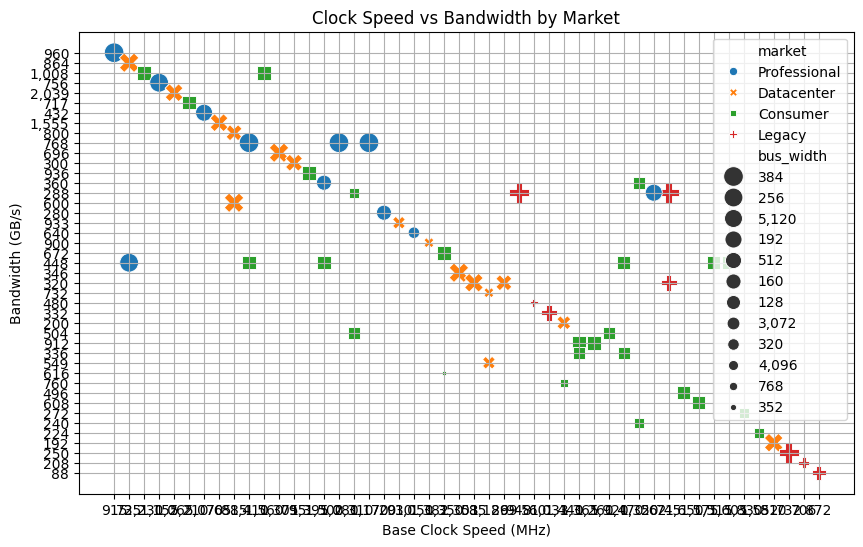

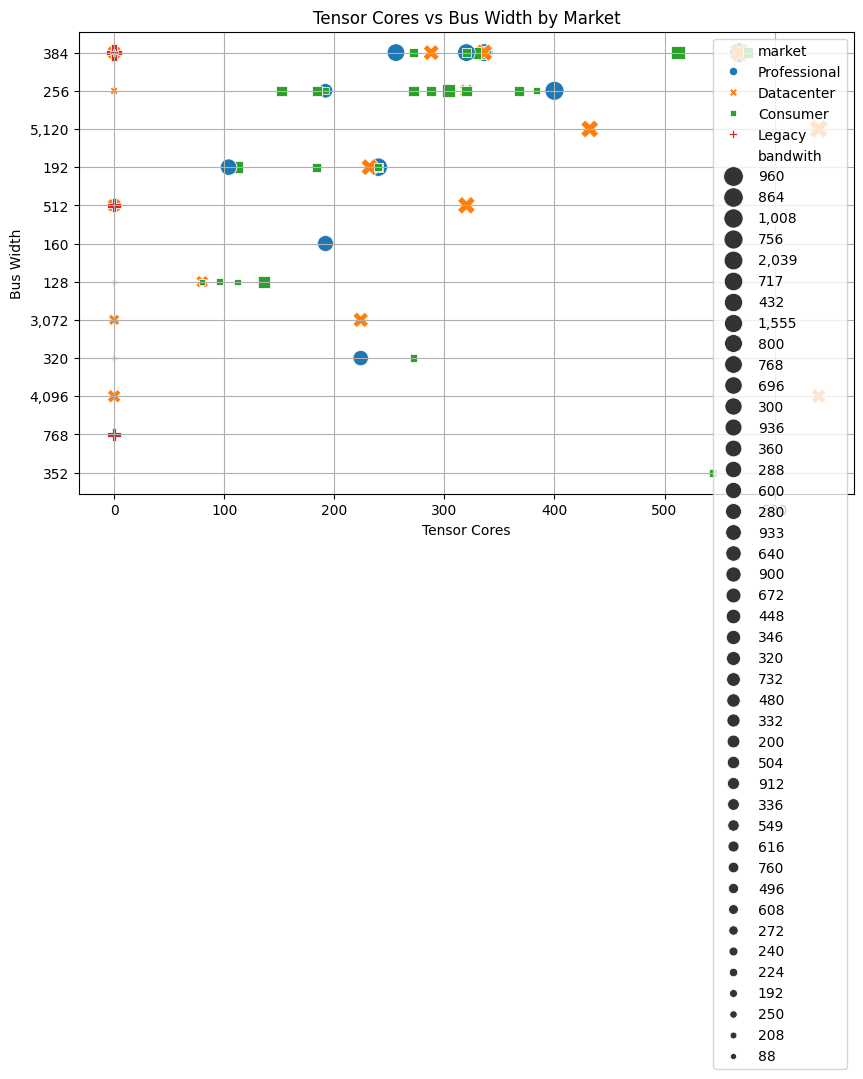

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot: Clock Speed vs. Bandwidth, colored by market
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='base_clock_mhz', y='bandwith', hue='market', style='market', size='bus_width', sizes=(20, 200))
plt.title('Clock Speed vs Bandwidth by Market')
plt.xlabel('Base Clock Speed (MHz)')
plt.ylabel('Bandwidth (GB/s)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Investigate Tensor Core impact on bus width
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='tensor_cores', y='bus_width', hue='market', style='market', size='bandwith', sizes=(20, 200))
plt.title('Tensor Cores vs Bus Width by Market')
plt.xlabel('Tensor Cores')
plt.ylabel('Bus Width')
plt.legend(loc='best')
plt.grid(True)
plt.show()


KeyError: "None of [Index(['tensor_cores_per_dollar', 'fp64_per_dollar', 'bandwidth_per_dollar'], dtype='object')] are in the [columns]"

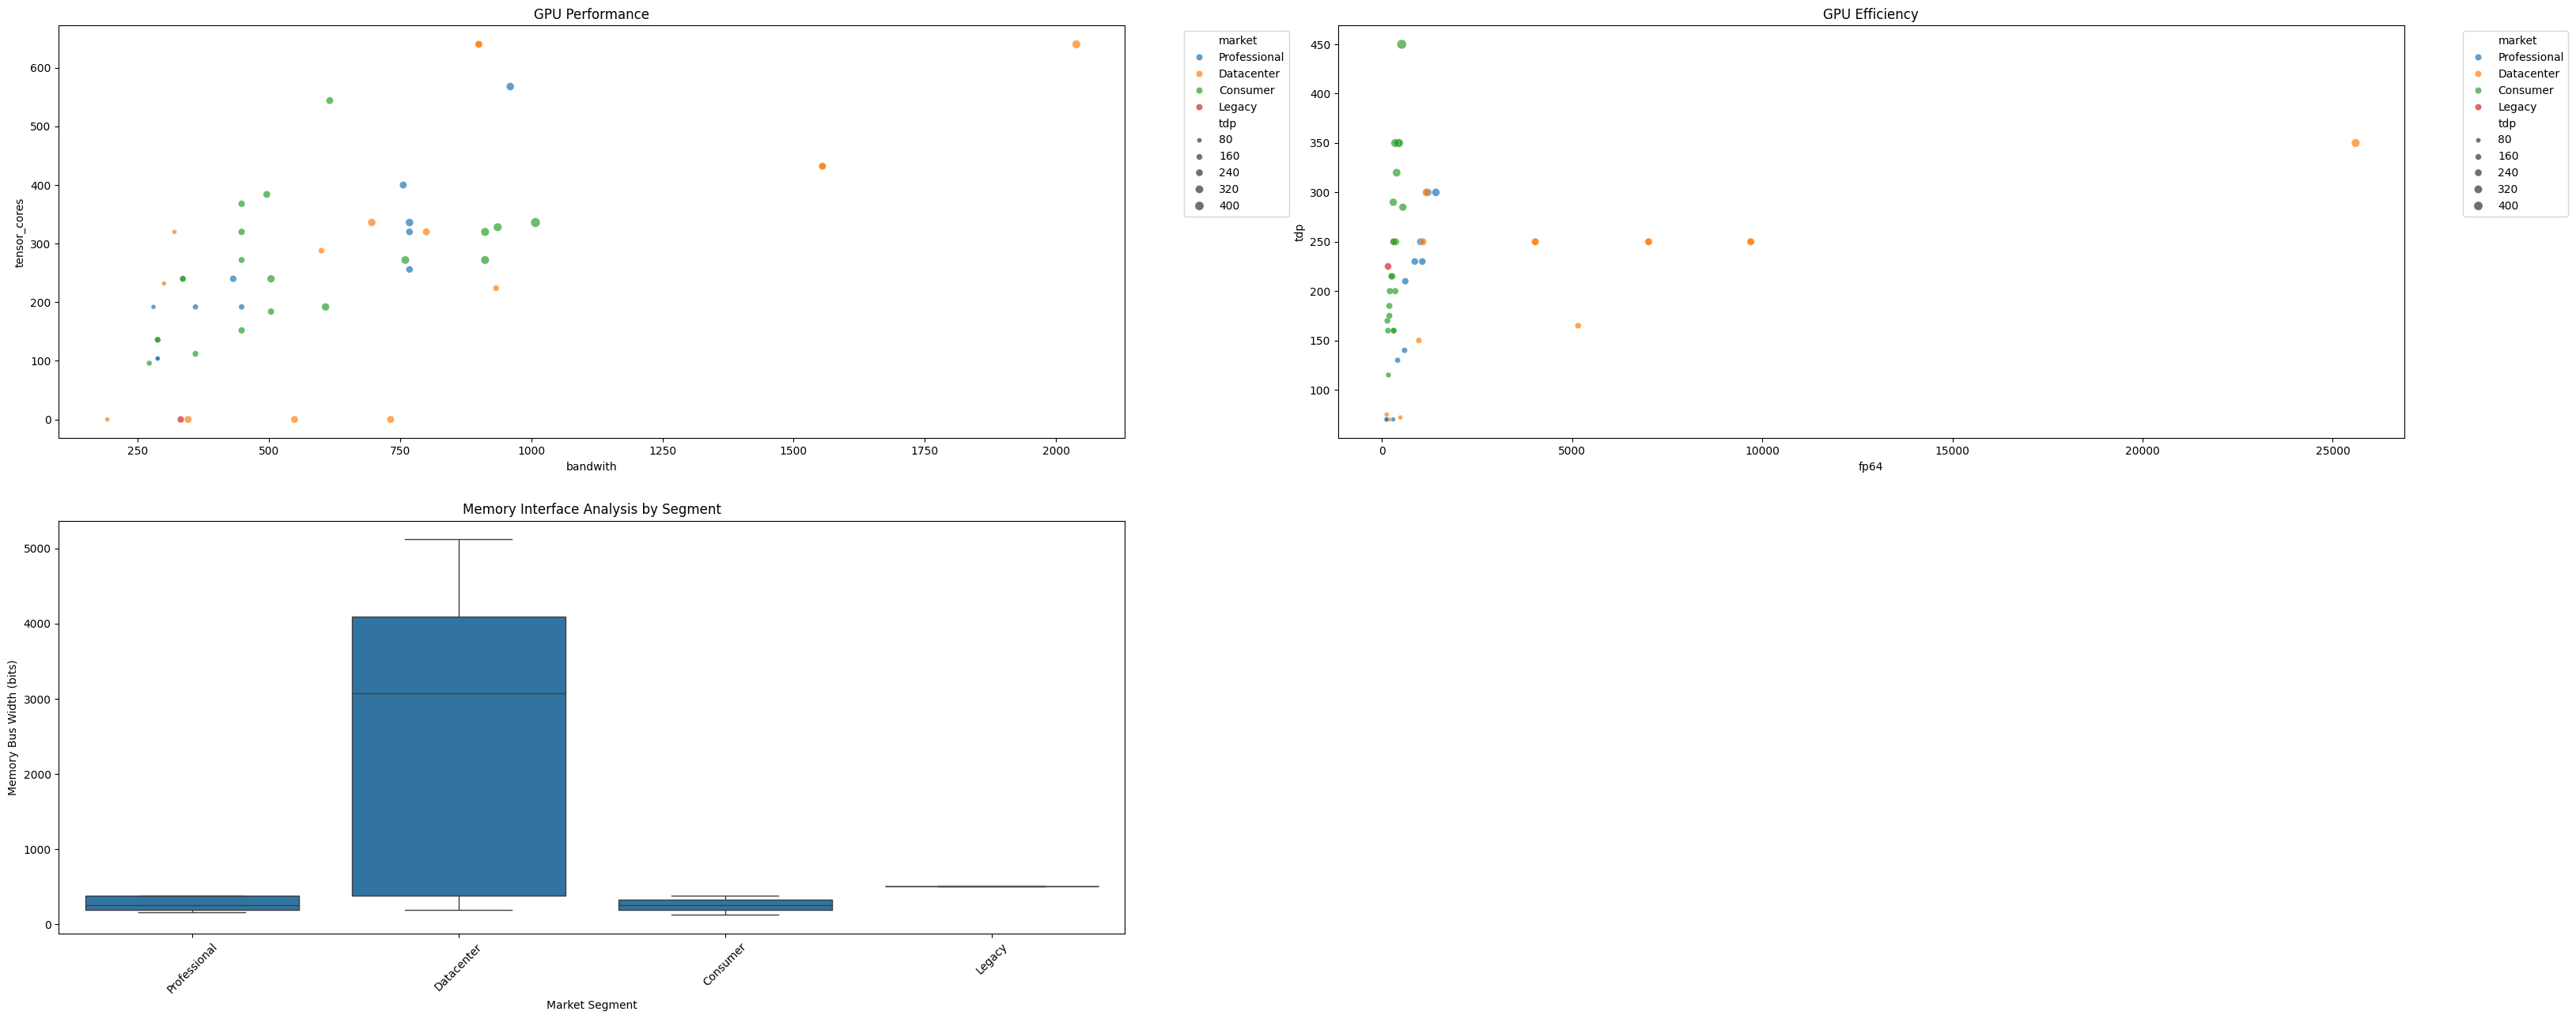

In [53]:
# Filter for recent GPUs (2016-2024)
df_filtered = df_cleaned[
    (pd.to_datetime(df_cleaned['release_date'], format='mixed', errors='coerce') < '2025-01-01') & 
    (pd.to_datetime(df_cleaned['release_date'], format='mixed', errors='coerce') > '2016-01-01')
].copy()

# Convert numeric columns more carefully
numeric_columns = ['tensor_cores', 'fp32', 'cuda_cores', 'bus_width', 'bandwith', 'fp64', 'tdp', 'price']
for col in numeric_columns:
    # Remove any non-numeric characters and convert
    df_filtered[col] = df_filtered[col].replace(r'[^\d.]', '', regex=True)
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')
    # Fill with median value for that column
    df_filtered[col] = df_filtered[col].fillna(df_filtered[col].median())

# Create figure and subplots first
fig = plt.figure(figsize=(80, 80))
gs = plt.GridSpec(10, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Create scatter plots without labels in the scatterplot call
scatter1 = sns.scatterplot(data=df_filtered,
                x='bandwith',
                y='tensor_cores',
                hue='market',
                size='tdp',
                alpha=0.7,
                ax=ax1)

scatter2 = sns.scatterplot(data=df_filtered,
                x='fp64',
                y='tdp',
                hue='market', 
                size='tdp',
                alpha=0.7,
                ax=ax2)

# Set titles for the plots
ax1.set_title('GPU Performance')
ax2.set_title('GPU Efficiency')

# Add legends with proper positioning
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 3: Memory Configuration Analysis
ax3 = fig.add_subplot(gs[1, 0])
valid_market_labels = df_filtered['market'].dropna().unique()
df_plot = df_filtered[df_filtered['market'].isin(valid_market_labels)]
sns.boxplot(data=df_plot,
            x='market',
            y='bus_width',
            ax=ax3)
ax3.set_title('Memory Interface Analysis by Segment')
ax3.set_xlabel('Market Segment')
ax3.set_ylabel('Memory Bus Width (bits)')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Price Efficiency Matrix
price_metrics = ['tensor_cores_per_dollar', 'fp64_per_dollar', 'bandwidth_per_dollar']
correlation_matrix = df_filtered[price_metrics].corr()
ax4 = fig.add_subplot(gs[1, 1])
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            ax=ax4)
ax4.set_title('Price Efficiency Correlation Matrix')

# Plot 5: Price vs Performance Timeline
ax5 = fig.add_subplot(gs[2, :])
metrics = ['tensor_cores_per_dollar', 'fp64_per_dollar', 'bandwidth_per_dollar']
for metric in metrics:
    sns.lineplot(data=df_filtered,
                x='release_date',
                y=metric,
                label=metric,
                ax=ax5)
ax5.set_title('Evolution of Price-Performance Ratio Over Time')
ax5.set_xlabel('Release Date')
ax5.set_ylabel('Performance per Dollar')
ax5.tick_params(axis='x', rotation=45)
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Print detailed analysis for different workloads
print("\n=== GPU Workload Analysis ===")

# AI/ML Optimized GPUs
print("\nBest GPUs for AI/ML Training:")
ai_metrics = ['model', 'tensor_cores', 'bandwith', 'tdp', 'price', 'tensor_cores_per_dollar', 'bandwidth_per_dollar']
top_ai = df_filtered.sort_values('tensor_cores', ascending=False).head(3)
for _, row in top_ai[ai_metrics].iterrows():
    print(f"\n{row['model']}:")
    print(f"- Tensor Cores: {int(row['tensor_cores'])}")
    print(f"- Memory Bandwidth: {int(row['bandwith'])} GB/s")
    print(f"- Power Draw: {int(row['tdp'])}W")
    print(f"- Price: ${int(row['price'])}")
    print(f"- Tensor Cores per Dollar: {row['tensor_cores_per_dollar']:.2f}")
    print(f"- Bandwidth per Dollar: {row['bandwidth_per_dollar']:.2f} GB/s/$")

# HPC Optimized GPUs
print("\nBest GPUs for HPC Workloads:")
hpc_metrics = ['model', 'fp64', 'bandwith', 'tdp', 'price', 'fp64_per_dollar', 'bandwidth_per_dollar']
top_hpc = df_filtered.sort_values('fp64', ascending=False).head(3)
for _, row in top_hpc[hpc_metrics].iterrows():
    print(f"\n{row['model']}:")
    print(f"- FP64 Performance: {row['fp64']} TFLOPS")
    print(f"- Memory Bandwidth: {int(row['bandwith'])} GB/s")
    print(f"- Power Draw: {int(row['tdp'])}W")
    print(f"- Price: ${int(row['price'])}")
    print(f"- FP64 TFLOPS per Dollar: {row['fp64_per_dollar']:.2f}")
    print(f"- Bandwidth per Dollar: {row['bandwidth_per_dollar']:.2f} GB/s/$")

# Gaming/Consumer GPUs
print("\nBest Consumer GPUs:")
consumer_metrics = ['model', 'cuda_cores', 'bandwith', 'tdp', 'price', 'bandwidth_per_dollar']
top_consumer = df_filtered[df_filtered['market'] == 'consumer'].sort_values('bandwith', ascending=False).head(3)
for _, row in top_consumer[consumer_metrics].iterrows():
    print(f"\n{row['model']}:")
    print(f"- CUDA Cores: {int(row['cuda_cores'])}")
    print(f"- Memory Bandwidth: {int(row['bandwith'])} GB/s")
    print(f"- Power Draw: {int(row['tdp'])}W")
    print(f"- Price: ${int(row['price'])}")
    print(f"- Bandwidth per Dollar: {row['bandwidth_per_dollar']:.2f} GB/s/$")

# Best Value Analysis
print("\n=== Best Value GPUs ===")
print("\nBest Value for AI/ML (Tensor Cores per Dollar):")
top_ai_value = df_filtered.sort_values('tensor_cores_per_dollar', ascending=False).head(3)
for _, row in top_ai_value[['model', 'tensor_cores_per_dollar', 'price', 'market']].iterrows():
    print(f"{row['model']} ({row['market']}): {row['tensor_cores_per_dollar']:.2f} cores/$ (Price: ${int(row['price'])})")

print("\nBest Value for HPC (FP64 per Dollar):")
top_hpc_value = df_filtered.sort_values('fp64_per_dollar', ascending=False).head(3)
for _, row in top_hpc_value[['model', 'fp64_per_dollar', 'price', 'market']].iterrows():
    print(f"{row['model']} ({row['market']}): {row['fp64_per_dollar']:.2f} TFLOPS/$ (Price: ${int(row['price'])})")

print("\nBest Value for Memory Bandwidth (GB/s per Dollar):")
top_bandwidth_value = df_filtered.sort_values('bandwidth_per_dollar', ascending=False).head(3)
for _, row in top_bandwidth_value[['model', 'bandwidth_per_dollar', 'price', 'market']].iterrows():
    print(f"{row['model']} ({row['market']}): {row['bandwidth_per_dollar']:.2f} GB/s/$ (Price: ${int(row['price'])})")

# Adjust layout with sufficient margins
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.1, right=0.9)
plt.show()
